# Blue gold preservation with trees

By Thomas Deurloo (https://www.kaggle.com/th0m4sd) & Simon Nouwens (https://www.kaggle.com/esquire900)

In this notebook we suggest an approach to estimate future water levels of multiple waterbodies in northern and central Italy. Nine different waterbodies of 4 distinct types (aquifers, water springs, rivers & lakes) are studied, each with different target variables. We aim to generate a single workflow for all different types of waterbodies, resulting in easy to interpret models. 

Hydrology can be seen as buckets of water, with in- & outflow depending on various parameters (physical parameter such as soil type, surface water etc.). This means that waterbodies often work on cutoff points; 10 mm rain might mostly infiltrate into the soil without reaching a river, while everything above that cutoff will directly add to the volume of the river. Tree algorithms work with cutoff points, and therefor can represent this behavior well; in our experience they work great in hydrology!

Water levels in water bodies can often be described as an interaction between weather and the physics of that specific waterbody. An accurate weather prediction with some knowledge of the waterbody would result in a great model, which is why this notebook puts a great focus on weather data, and leaves the physical properties of the waterbody to be extracted by machine learning models.

We aim for this notebook to be concise and to the point and will therefor not extensively analyse each of the 24 target measurements or all of the input parameters, but leave the reader with documented code to further dive into points of his or her interest.

In [17]:
# download and unzip the git archive for this project
!wget https://github.com/thomas-wsbd/acea-water-prediction/archive/main.zip
!unzip ./main.zip
!cp ./acea-water-prediction-main/utils.py ./
!mkdir data
!cp -r ./acea-water-prediction-main/data/* ./data/

!mkdir sim-res-final
!cp -r ./acea-water-prediction-main/sim-res-final/* ./sim-res-final/
# install dependencies
!pip install lightgbm pandas geopandas scikit-learn colorlover plotly shap matplotlib optuna

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/simon/.wget-hsts'. HSTS will be disabled.
--2021-02-17 16:40:20--  https://github.com/thomas-wsbd/acea-water-prediction/archive/main.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/thomas-wsbd/acea-water-prediction/zip/main [following]
--2021-02-17 16:40:20--  https://codeload.github.com/thomas-wsbd/acea-water-prediction/zip/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [   <=>              ]  32.95M  5.50MB/s    in 6.6s    

2021-02-17 16:40:27 (5.02 MB/s

# Executive summary

- External NASA weather data is collected surrounding the waterbody locations, and all data is cleaned and organized.
- The data is analyzed, based on which custom features are engineered in an easy-to-interpret manner. 
- Those features are used as inputs for Gradient Boosted Tree (GBM) models. Three different models are generated for each target; aiming to predict the water levels 14, 28 and 56 days ahead. Both the models and our preprocessing choices are optimized, aiming for the lowest Mean Average Error (MAE) on the validation datasets. The normalized MAE score of all models is 0.04067, implying that the models make decent predictions of the target measurements.

This pipeline results in scores displayed below. As the different targets are hard to relate to eachother we do not compute aggregate scores over multiple datasets. The combination of this notebook and extra downloadable scripts leaves the user with a single framework to further explore the existing datasets, or expand the currently used locations to predict other target measurements or waterbodies.

In [1]:
import pandas as pd
import os, json
import matplotlib.pyplot as plt
import shap
import optuna
import json
from utils import *

df_info = pd.read_json("./sim-res-final/info.json")
print("-------- Normalized MAE scores grouped by the number of days predicted in advance")
print(df_info.groupby(["pred_ahead"]).mae_normalized_test.describe()[['mean', 'std', '50%']]) # normalized mae per # days ahead

print("\n-------- Absolute MAE scores grouped per dataset")
print(df_info.groupby(["dataset"]).mae_test.describe()[['mean', 'std', '50%']]) # normalized mae per # days ahead


-------- Normalized MAE scores grouped by the number of days predicted in advance
                mean       std       50%
pred_ahead                              
14          0.053736  0.129586  0.011140
28          0.068146  0.148796  0.015284
56          0.085406  0.151029  0.024061

-------- Absolute MAE scores grouped per dataset
                                      mean       std        50%
dataset                                                        
aquifer_auser                     0.262369  0.173030   0.212645
aquifer_doganella                 1.406205  1.536617   0.819115
aquifer_luco                      0.081227  0.038088   0.072402
aquifer_petrignano                0.383945  0.167282   0.334994
lake_bilancino                    1.228566  0.702943   1.219918
river_arno                        0.315429  0.014488   0.323532
water_spring_amiata               0.303286  0.284234   0.310041
water_spring_lupa                 3.413806  2.022432   2.459766
water_spring_madonna_di

# Data gathering & cleaning

As mentioned in the introduction, waterbodies are best described as an interaction between weather and the physical system, making weather the most relevant available data to predict water levels. We collect weather data from NASA's POWER system (https://power.larc.nasa.gov/) as external dataset. It's API offers very specific weather features for any location on earth, making it ideal for our requirements.

Based on the given names of the waterbodies, 57 locations of interest are determined, for each which 16 weather metrics (rain, humidity, temperature and wind speeds) are collected in a daily timeframe going back to 2000. We combine this external dataset with the given datasets and manually clean up a number inconsistencies in the data, the details of which are commented in the code. For the features, missing values are filled with a quadratic interpolation. The missing values of the target variables are left empty so we don't train models on guessed measurements, only on actual data. Water levels are long-tailed distributions as the incoming water they depend on are non-normally distributed (Watterson and Dix (2003)). This means we only clean the obviously faulty data such as 0-values, but remove no further outliers.

# Exploratory data analysis

- show why we np.log the target variables


# Methods

## Feature engineering

Feature engineering is done by dimension reduction of the weather data. Per data type (i.e. ws10m, the wind speed at 10m altitude, or rainfall), we multiply the data points D with a location weight matrix W and take the mean, where W is optimized. This approach offers several advantages over other dimension reduction techniques:
- The dimension reduction is significant, for example the 16 NASA POWER features over 10 locations (160 features) are reduced to 16 features
- The resulting features are still easy to interpret, as they directly represent weather conditions, such as "rain" or "wind speed"
- By hyperoptimizing W, we get an optimal location vector that directly represents how important a certain location is for a target variable 

We do this for both the NASA POWER data and the internal dataset that is given, resulting in the following features:
- 16 NASA POWER weather features (wind speed, temperature, etc.)
- target variables (# features is variable per dataset)
- Internal data set features (# features is variable per dataset)
- Several date related features: month (1-12, categorical), week (1-52, continuous) & day_of_week (1-7, categorical). The continuous week variable helps the model with seasonality, while the other 2 categorical variables assist in detecting date based artifacts, such as the ones found in target_flow_rate_galleria_alta. Adding yearly data often hurts performance (referentie?)

Finally some historical data needs to be taken into account. We add 8 shifted rolling means for each of the previously mentioned features: rolling mean of period 2 shifted back 1, 3 & 5 days, rolling mean of period 5 shifted back 5, 10 & 15 days, and the rolling mean of period 20 shifted back 20 and 40 days. This gives the model plenty of data to work with without getting a huge number of features.

## Training
Using the engineered features, we split the data into a train, validation and test chunck in a 70-10-20 fashion, and train a GBM model. The training data is used as input, the validation data for early stopping and parameter optimization. The test dataset is used for final metric reporting. Since we only train model on data where the target variable is non-null, the exact split dates differ per dataset.

For every target variable we generate 3 models: predicting 14, 28 and 56 days ahead. Targets are not predicted directly, but normalized into a logged percentual change, so that 
`target_14 = log(target(t-14) / target(t) + 1)`. Taking the log of the target generally assists models when trying to predict non-normally distributed targets. Training multiple models is preferable over a single one with multiple targets, since predicting 14 days ahead allows using training data up to t-14 (where t is the current day), while predicting 56 days ahead only allows data up to t-56. The table below describes the starting date and the length in days of the test dataset, per dataset and per time horizon.

For every model, we optimze a number of parameters, including both hyperparameters of the GBM algorithm and other variables such as the location matrix W and how the data is preprocessed. The optimization is done with Optuna (Akiba et al, 2019) with 100 trials for each model.

In [2]:
df_info.groupby(["dataset", 'pred_ahead']).last()[['dfp_test_start','dfp_test_length']]

dfp_test_start  \
dataset                         pred_ahead                        
aquifer_auser                   14          2018-05-28 00:00:00   
                                28          2018-05-30 00:00:00   
                                56          2018-06-04 00:00:00   
aquifer_doganella               14          2019-04-18 00:00:00   
                                28          2019-04-20 00:00:00   
                                56          2019-04-24 00:00:00   
aquifer_luco                    14          2018-09-12 00:00:00   
                                28          2018-09-12 00:00:00   
                                56          2018-09-12 00:00:00   
aquifer_petrignano              14          2018-05-12 00:00:00   
                                28          2018-05-14 00:00:00   
                                56          2018-05-18 00:00:00   
lake_bilancino                  14          2017-10-17 00:00:00   
                                28          2017-10-19 00:00:00   
                                56          2017-10-23 00:00:00   
river_arno                      14          2017-02-17 00:00:00   
                                28          2017-02-19 00:00:00   
                                56          2017-02-23 00:00:00   
water_spring_amiata             14          2019-09-06 00:00:00   
                                28          2019-09-09 00:00:00   
                                56          2019-09-13 00:00:00   
water_spring_lupa               14          2018-10-20 00:00:00   
                                28          2018-10-22 00:00:00   
                                56          2018-10-26 00:00:00   
water_spring_madonna_di_canneto 14          2019-09-17 00:00:00   
                                28          2019-09-19 00:00:00   
                                56          2019-09-23 00:00:00   

                                            dfp_test_length  
dataset                         pred_ahead                   
aquifer_auser                   14                      724  
                                28                      711  
                                56                      678  
aquifer_doganella               14                      390  
                                28                      376  
                                56                      344  
aquifer_luco                    14                      123  
                                28                      123  
                                56                      123  
aquifer_petrignano              14                      756  
                                28                      740  
                                56                      708  
lake_bilancino                  14                      974  
                                28                      958  
                                56                      926  
river_arno                      14                     1214  
                                28                     1198  
                                56                     1166  
water_spring_amiata             14                      285  
                                28                      268  
                                56                      236  
water_spring_lupa               14                      589  
                                28                      573  
                                56                      541  
water_spring_madonna_di_canneto 14                      262  
                                28                      246  
                                56                      214

In [3]:


def run_optimization():
    result_folder = "sim-res-final"

    info_file_name = "./{}/info.json".format(result_folder)
    info = []

    for dataset in DATA_SETS:
        df = gather_df(dataset, True)
        target_cols = [c for c in df.columns if "target" in c]

        for target_col in target_cols:
            for pred_ahead in [14, 28, 56]:
                # compute the size of location_matrix_W, which is variable per dataset
                n_feats = (
                    len([c for c in df.columns if "ws10m_max" in c])
                    + len([c for c in df.columns if "rainfall" in c])
                    + len([c for c in df.columns if "temperature" in c])
                )

                # this is the optimization function that we are going to hyperoptimize
                def objective(trial, return_dataframes=False):
                    location_array_W = []
                    for i in range(n_feats):
                        location_array_W.append(trial.suggest_float("W_{}".format(i), 0, 1))
                    dfp_val, dfp_test, lgb_model, _ = model_function(
                        dataset,
                        location_array_W,
                        pred_ahead,
                        target_col,
                        extended_data=trial.suggest_categorical(
                            "extended_data", [True, False]
                        ),
                        impute_missing=trial.suggest_categorical(
                            "impute_missing", [True, False]
                        ),
                        do_extract=trial.suggest_categorical("do_extract", [True, False]),
                        shift_features=trial.suggest_categorical(
                            "shift_features", [True, False]
                        ),
                        use_early_stopping=trial.suggest_categorical(
                            "use_early_stopping", [True, False]
                        ),
                        lgb_boosting_type=trial.suggest_categorical(
                            "lgb_boosting_type", ["gbdt", "goss", "dart"]
                        ),
                        lgb_num_leaves=trial.suggest_categorical(
                            "lgb_num_leaves", [10, 31, 50]
                        ),
                        lgb_learning_rate=trial.suggest_uniform(
                            "lgb_learning_rate", 0.01, 0.3
                        ),
                        lgb_max_depth=trial.suggest_int(
                            "lgb_max_depth", -1, 10
                        ),  # -1 here means infinite
                    )
                    if return_dataframes:
                        return dfp_val, dfp_test
                    return np.mean(
                        np.abs(dfp_val.p - dfp_val.y)
                    )  # we optimize on the MAE of the validation dataset

                study = optuna.create_study()
                study.optimize(objective, n_trials=100)

                # the outputting dataframe with optimal parameters
                location_array_W_optim = []
                for k, v in study.best_params.items():
                    if "W_" in k:
                        location_array_W_optim.append(v)

                dfp_val, dfp_test, lgb_model, _ = model_function(
                    dataset,
                    location_array_W_optim,
                    pred_ahead,
                    target_col,
                    extended_data=study.best_params["extended_data"],
                    impute_missing=study.best_params["impute_missing"],
                    do_extract=study.best_params["do_extract"],
                    shift_features=study.best_params["shift_features"],
                    use_early_stopping=study.best_params["use_early_stopping"],
                    lgb_boosting_type=study.best_params["lgb_boosting_type"],
                    lgb_num_leaves=study.best_params["lgb_num_leaves"],
                    lgb_learning_rate=study.best_params["lgb_learning_rate"],
                    lgb_max_depth=study.best_params["lgb_max_depth"],
                )

                run_id = np.random.randint(1, 100000000000000)

                mae_test = np.mean(np.abs(dfp_test.p - dfp_test.y))
                rmse_test = np.sqrt(np.mean((dfp_test.p - dfp_test.y) ** 2))

                mae_val = np.mean(np.abs(dfp_val.p - dfp_val.y))
                rmse_val = np.sqrt(np.mean((dfp_val.p - dfp_val.y) ** 2))

                info.append(
                    {
                        "run_id": run_id,
                        "best_params": study.best_params,
                        "location_weights": location_array_W_optim,
                        "dataset": dataset,
                        "target_col": target_col,
                        "pred_ahead": pred_ahead,
                        "mae_test": mae_test,
                        "rmse_test": rmse_test,
                        "mae_val": mae_val,
                        "rmse_val": rmse_val,
                        "dfp_test_start": str(dfp_test.index[0]),
                        "dfp_test_length": len(dfp_test.index),
                        "mae_normalized_val": (
                            np.abs((dfp_val.y - dfp_val.p))
                            / np.abs(dfp_val.original.mean())
                        ).mean(),
                        "mae_normalized_test": (
                            np.abs((dfp_test.y - dfp_test.p))
                            / np.abs(dfp_test.original.mean())
                        ).mean(),
                    }
                )

                with open(info_file_name, "w+") as f:
                    json.dump(info, f)
                dfp_val.reset_index().to_feather(
                    "./{}/{}-validation.feather".format(result_folder, run_id)
                )
                dfp_test.reset_index().to_feather(
                    "./{}/{}-test.feather".format(result_folder, run_id)
                )
print('Running the optimization may take several hours, uncomment the function call at the bottom of this cell to start a new run.')
# run_optimization()

Running the optimization may take several hours, uncomment the function call at the bottom of this cell to start a new run.


# Findings

The tables below summarize the results of all our models: 72 in total, 3 for every target variable. The first table shows the average MAE and RMSE scores per target variable (the average is over the 3 different time horizons). The normalized MAE allows for easy comparison between datasets, while the "mae_test" and "rmse_test" columns show absolute metrics. It's quite obvious that the model performs significantly better in some area's then others. Most of the predictions in Aquifer Doganella have small errors, though the depth_to_groundwater_pozzo_1 metric appears hard to predict with this pipeline.

In [4]:
print("\n-------- Absolute MAE scores grouped per dataset")
df_info.groupby(["dataset", 'target_col'])['mae_normalized_test', 'mae_test', 'rmse_test'].mean()


-------- Absolute MAE scores grouped per dataset


Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


mae_normalized_test  \
dataset                         target_col                                                        
aquifer_auser                   target_depth_to_groundwater_cos                        0.074789   
                                target_depth_to_groundwater_lt2                        0.009460   
                                target_depth_to_groundwater_sal                        0.040425   
aquifer_doganella               target_depth_to_groundwater_pozzo_1                    0.100613   
                                target_depth_to_groundwater_pozzo_2                    0.006212   
                                target_depth_to_groundwater_pozzo_3                    0.023146   
                                target_depth_to_groundwater_pozzo_4                    0.007464   
                                target_depth_to_groundwater_pozzo_5                    0.001937   
                                target_depth_to_groundwater_pozzo_6                    0.009900   
                                target_depth_to_groundwater_pozzo_7                    0.006833   
                                target_depth_to_groundwater_pozzo_8                    0.008189   
                                target_depth_to_groundwater_pozzo_9                    0.014333   
aquifer_luco                    target_depth_to_groundwater_podere_casetta             0.010676   
aquifer_petrignano              target_depth_to_groundwater_p24                        0.015947   
                                target_depth_to_groundwater_p25                        0.013903   
lake_bilancino                  target_flow_rate                                       0.692012   
                                target_lake_level                                      0.002424   
river_arno                      target_hydrometry_nave_di_rosano                       0.212078   
water_spring_amiata             target_flow_rate_arbure                                0.073262   
                                target_flow_rate_bugnano                               0.051454   
                                target_flow_rate_ermicciolo                            0.132158   
                                target_flow_rate_galleria_alta                         0.019767   
water_spring_lupa               target_flow_rate_lupa                                  0.031134   
water_spring_madonna_di_canneto target_flow_rate_madonna_di_canneto                    0.100184   

                                                                             mae_test  \
dataset                         target_col                                              
aquifer_auser                   target_depth_to_groundwater_cos              0.450162   
                                target_depth_to_groundwater_lt2              0.119946   
                                target_depth_to_groundwater_sal              0.216999   
aquifer_doganella               target_depth_to_groundwater_pozzo_1          4.732180   
                                target_depth_to_groundwater_pozzo_2          0.628048   
                                target_depth_to_groundwater_pozzo_3          2.603067   
                                target_depth_to_groundwater_pozzo_4          0.761409   
                                target_depth_to_groundwater_pozzo_5          0.202341   
                                target_depth_to_groundwater_pozzo_6          0.937757   
                                target_depth_to_groundwater_pozzo_7          0.660987   
                                target_depth_to_groundwater_pozzo_8          0.810851   
                                target_depth_to_groundwater_pozzo_9          1.319203   
aquifer_luco                    target_depth_to_groundwater_podere_casetta   0.081227   
aquifer_petrignano              target_depth_to_groundwater_p24              0.413136   
                                target_depth_to_groundwater_p25              

The table below shows the average normalized MAE scores per time window per dataset. Most scores appear in a pattern that one may expect: the error grows as the prediction time horizon grows larger. The exception seem to be lake bilancino and river arno, which appear to be difficult to predict in the first place, but keep a similar error rate over different time horizons.

In [5]:
print("\n-------- Normalized MAE scores grouped per dataset and time window")
df_info.groupby(["dataset", 'pred_ahead']).mae_normalized_test.describe()[['mean']].unstack()


-------- Normalized MAE scores grouped per dataset and time window


mean                    
pred_ahead                             14        28        56
dataset                                                      
aquifer_auser                    0.026862  0.043488  0.054324
aquifer_doganella                0.013951  0.021132  0.024460
aquifer_luco                     0.006352  0.009516  0.016161
aquifer_petrignano               0.008972  0.013035  0.022767
lake_bilancino                   0.312395  0.365570  0.363688
river_arno                       0.217449  0.200936  0.217849
water_spring_amiata              0.033080  0.058801  0.115600
water_spring_lupa                0.018855  0.022535  0.052011
water_spring_madonna_di_canneto  0.065815  0.089441  0.145297

To show the interpretability of the presented pipeline, we select the first of the model and interpret the underlying components. This is the model that is trained to predict the "target_depth_to_groundwater_lt2" variable in the Aquafer Auser dataset, with a 14 day time window. The first plot displays the target (y, in blue) and the predicted values(p, in orange). The predicted values are close to the target, but slightly lagging in sharpe trends.

The second figure blow, SHAP value plot, explains how features impact the model output. A clear relation for example is the '\_ps' variable, the surface pressure. The lower the surface air pressure, the more impact the variable has on the model.

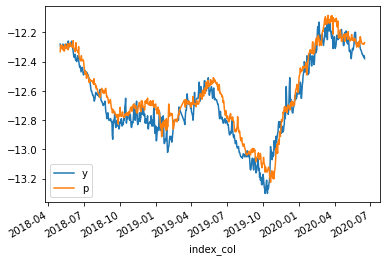

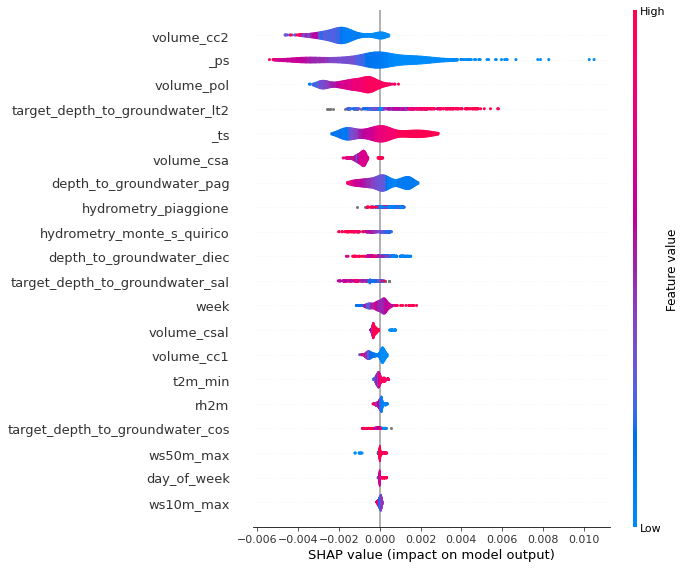

In [6]:
df_info = pd.read_json("./sim-res-final/info.json")
run = df_info.iloc[0]

dfp_val, dfp_test, lgb_model, X_test, y_test = model_function(
    run.dataset,
    run.location_weights,
    run.pred_ahead,
    run.target_col,
    extended_data=run.best_params["extended_data"],
    impute_missing=run.best_params["impute_missing"],
    do_extract=run.best_params["do_extract"],
    shift_features=run.best_params["shift_features"],
    use_early_stopping=run.best_params["use_early_stopping"],
    lgb_boosting_type=run.best_params["lgb_boosting_type"],
    lgb_num_leaves=run.best_params["lgb_num_leaves"],
    lgb_learning_rate=run.best_params["lgb_learning_rate"],
    lgb_max_depth=run.best_params["lgb_max_depth"],
)

dfp_test[['y', 'p']].plot()
plt.show()

shap_values = shap.TreeExplainer(lgb_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test,plot_type="violin")

If we look at a random specific example below, with a shap forceplot like the one shown below, it's trivial to reason about the model. The final answer for this datapoint of the model is slightly negative; it expected that the depth to the groundwater will be slightly lower in 14 days compared to the current level. We can see that the '\_ts', the earth skin temperature, has a large impact to make this value close to 0. The \_ts variable for this instance is relatively high (11.9 compared to an average 6.72); the high skin temperature let's the model believe the target variable will end up higher. The \_ts variable here is simply the mean of the weighted earth skin termperatures of multiple locations.

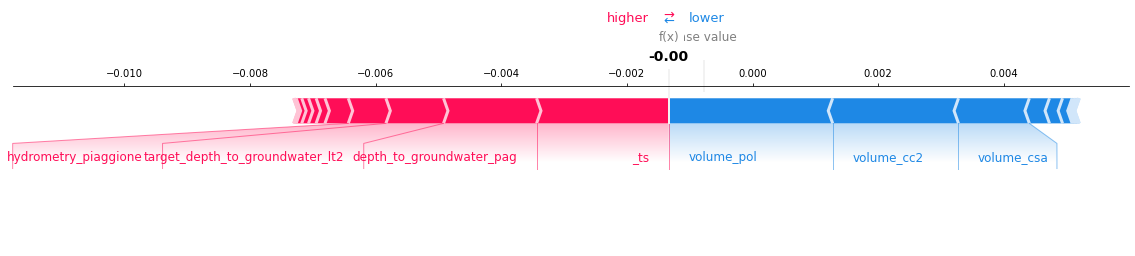

In [7]:
explainer = shap.TreeExplainer(lgb_model)
expected_value = explainer.expected_value

shap.force_plot(expected_value, shap_values[100], lgb_model.feature_name_,  matplotlib=True)

If we look at the location weights of this specific model, it's apparent that some locations (Gallicano, Lucca Orto Botanico) have far more importance then others (Croce Arcana).

In [8]:
df = gather_df(run.dataset, True)
target_cols = [c for c in df.columns if "target" in c]

for target_col in target_cols:
    for pred_ahead in [14, 28, 56]:
        # compute the size of location_matrix_W, which is variable per dataset
        n_feats = [
            [c for c in df.columns if "ws10m_max" in c],
            [c for c in df.columns if "rainfall" in c],
            [c for c in df.columns if "temperature" in c],
        ]
location_W_names = []
[[location_W_names.append(a.replace("_ws10m_max", "")) for a in b] for b in n_feats]
df_locations = pd.DataFrame(
    {"location_weight": run.location_weights, "location_name": location_W_names}
)
print(df_locations.sort_values("location_weight").head())
print(df_locations.sort_values("location_weight").tail())

    location_weight                            location_name
7          0.001784                             croce_arcana
20         0.002015  rainfall_tereglio_coreglia_antelminelli
19         0.004533                    rainfall_croce_arcana
8          0.182114           tereglio_coreglia_antelminelli
24         0.217798              temperature_ponte_a_moriano
    location_weight             location_name
6          0.590280                 calavorno
14         0.645115      rainfall_monte_serra
16         0.784542  rainfall_borgo_a_mozzano
11         0.803401       lucca_orto_botanico
12         0.815247        rainfall_gallicano


# Discussion

We've presented a relatively simple pipeline that is easy interpret and reason about, but still gives (mostly) decent predictions about the desired target variables. We've only shown a single example for brevity purposes, though an interested reader can easily analyse other models, features and datapoints to get usable insights. We shortly touch the advantages & disadvantages of our model, and discuss a number of points of interest that might need to be considered for this dataset. 

- Since the usage of future (weather) predictions as input for the model is restricted in this competition, the resulting models will by definition be a combination of weather predictions and physical properties of the studied system.
- Retraining models after a certain period (i.e. every week or every month), significantly increases the models performance. 
- The current measurements are likely influenced by human intervention, i.e. the opening or closing of dams. We could not find a dataset which described these actions so we couldn't account for it. If actions are taken based on the predictions of a model that's trained on this kind of biased data, there is risk of a feedback loop where the model makes predictions as if an intervening action will be made.

Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta,and Masanori Koyama. 2019.
Optuna: A Next-generation Hyperparameter Optimization Framework. In KDD.

Watterson, I., , and M. Dix, 2003: Simulated changes due to global warming in daily precipitation means and extremes and their interpretation using the gamma distribution. J. Geophys. Res., 108, 4379, doi:10.1029/2002JD002928.

